# MASS database inspection

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pprint

project_root = os.path.abspath('..')
sys.path.append(project_root)

from sleeprnn.data.mass_ss import MassSS
from sleeprnn.data.mass_kc import MassKC
from sleeprnn.data.dataset import KEY_EEG, KEY_N2_PAGES, KEY_ALL_PAGES, KEY_MARKS
from sleeprnn.data.utils import seq2stamp, stamp2seq, seq2stamp_with_pages, power_spectrum
from sleeprnn.detection.metrics import by_sample_confusion, by_sample_iou, by_event_confusion, matching
from sleeprnn.common import constants, pkeys, checks

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
dataset = MassSS(load_checkpoint=True)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482037


## FFT on events

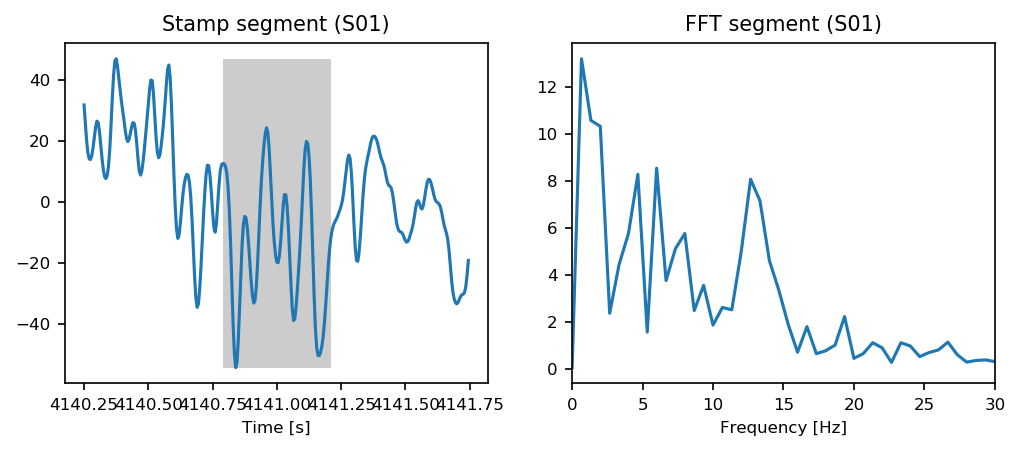

In [3]:
fft_segment_size = 1.5
subject_id = 1
which_stamp = 20

this_signal = dataset.get_subject_signal(
    subject_id, normalize_clip=False, verbose=True)
this_stamps = dataset.get_subject_stamps(
    subject_id, which_expert=1, pages_subset=constants.N2_RECORD)

single_stamp = this_stamps[which_stamp, :]
single_stamp_center = single_stamp.mean()
start_crop = int(single_stamp_center - fft_segment_size * dataset.fs / 2)
end_crop = int(start_crop + fft_segment_size * dataset.fs)
signal_for_fft = this_signal[start_crop:end_crop]
this_power, this_freq = power_spectrum(signal_for_fft, dataset.fs)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
ax[0].plot(np.arange(start_crop, end_crop) / dataset.fs, signal_for_fft)
ax[0].fill_between(
    np.arange(single_stamp[0], single_stamp[1]) / dataset.fs, signal_for_fft.max(), signal_for_fft.min(),
    facecolor='k', alpha=0.2
)
ax[0].set_title('Stamp segment (S%02d)' % subject_id, fontsize=10)
ax[0].set_xlabel('Time [s]', fontsize=8)
ax[0].tick_params(labelsize=8)

ax[1].set_title('FFT segment (S%02d)' % subject_id, fontsize=10)
ax[1].plot(this_freq, this_power)
ax[1].set_xlabel('Frequency [Hz]', fontsize=8)
ax[1].tick_params(labelsize=8)
ax[1].set_xlim([0, 30])
# ax[1].set_yscale('log')

plt.show()

In [9]:
# Average for all stamps

dataset = MassSS(load_checkpoint=True)

fft_segment_size = 2

all_power_train = []
all_power_test = []

for subject_id in dataset.train_ids:

    this_signal = dataset.get_subject_signal(
        subject_id, normalize_clip=False, which_expert=1)
    this_stamps = dataset.get_subject_stamps(
        subject_id, which_expert=1, pages_subset=constants.N2_RECORD)

    all_power = []
    for single_stamp in this_stamps:
        single_stamp_center = single_stamp.mean()
        start_crop = int(single_stamp_center - fft_segment_size * dataset.fs / 2)
        end_crop = int(start_crop + fft_segment_size * dataset.fs)
        signal_for_fft = this_signal[start_crop:end_crop]
        this_power, this_freq = power_spectrum(signal_for_fft, dataset.fs)
        all_freq = this_freq
        all_power.append(this_power)
    all_power = np.stack(all_power, axis=0).mean(axis=0)
    all_power_train.append(all_power)
    
for subject_id in dataset.test_ids:
    this_signal = dataset.get_subject_signal(
        subject_id, normalize_clip=False, which_expert=1)
    this_stamps = dataset.get_subject_stamps(
        subject_id, which_expert=1, pages_subset=constants.N2_RECORD)

    all_power = []
    for single_stamp in this_stamps:
        single_stamp_center = single_stamp.mean()
        start_crop = int(single_stamp_center - fft_segment_size * dataset.fs / 2)
        end_crop = int(start_crop + fft_segment_size * dataset.fs)
        signal_for_fft = this_signal[start_crop:end_crop]
        this_power, this_freq = power_spectrum(signal_for_fft, dataset.fs)
        all_freq = this_freq
        all_power.append(this_power)
    all_power = np.stack(all_power, axis=0).mean(axis=0)
    all_power_test.append(all_power)

max_power = max(np.concatenate(all_power_train).max(), np.concatenate(all_power_test).max())

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482037


In [10]:
sigma_band = np.where((all_freq >= 11) & (all_freq <= 16))[0]
all_power_sigma_test = []
all_relative_power_sigma_test = []
all_peak_power_sigma_test = []
for k, subject_id in enumerate(dataset.test_ids):
    this_power = all_power_test[k]
    this_power_sigma = this_power[sigma_band]
    sum_power = this_power.sum()
    sum_power_sigma = this_power_sigma.sum()
    relative_power_sigma = sum_power_sigma / sum_power
    all_power_sigma_test.append(sum_power_sigma)
    all_relative_power_sigma_test.append(relative_power_sigma)
    all_peak_power_sigma_test.append(this_power_sigma.max())
all_power_sigma_train = []
all_relative_power_sigma_train = []
all_peak_power_sigma_train = []
for k, subject_id in enumerate(dataset.train_ids):
    this_power = all_power_train[k]
    this_power_sigma = this_power[sigma_band]
    sum_power = this_power.sum()
    sum_power_sigma = this_power_sigma.sum()
    relative_power_sigma = sum_power_sigma / sum_power
    all_power_sigma_train.append(sum_power_sigma)
    all_relative_power_sigma_train.append(relative_power_sigma)
    all_peak_power_sigma_train.append(this_power_sigma.max())

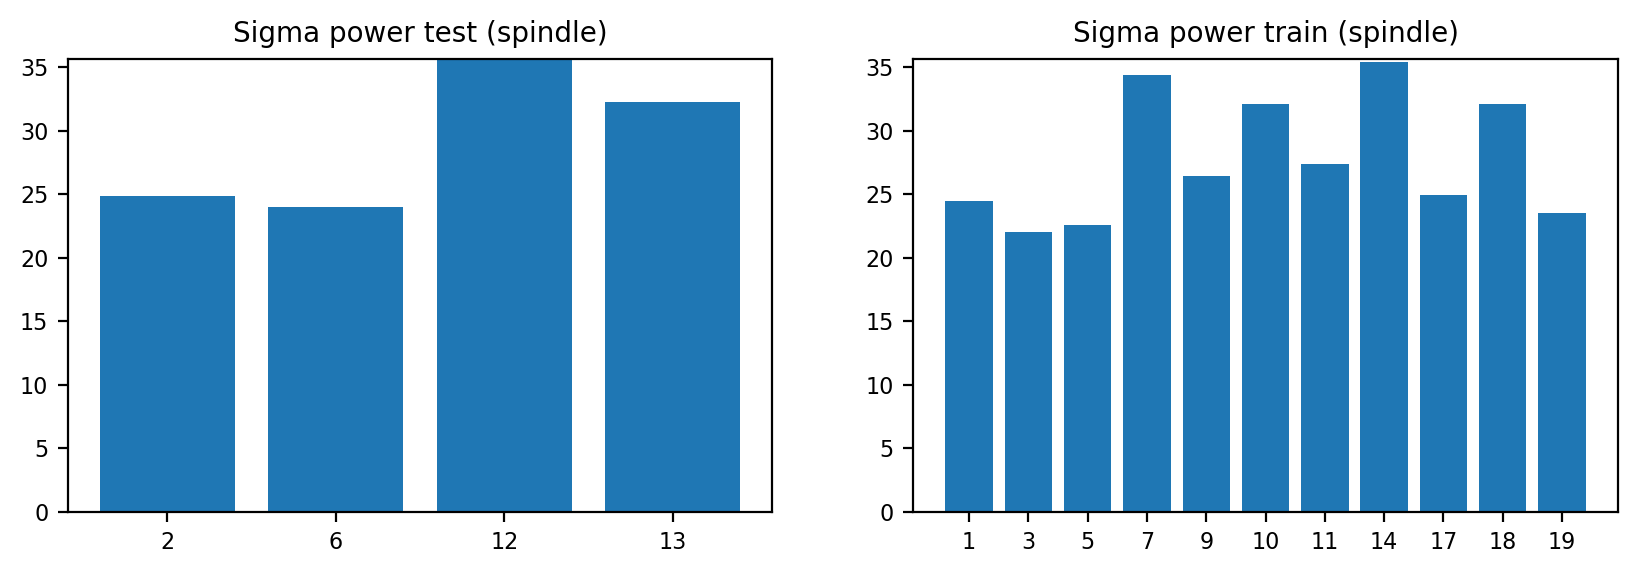

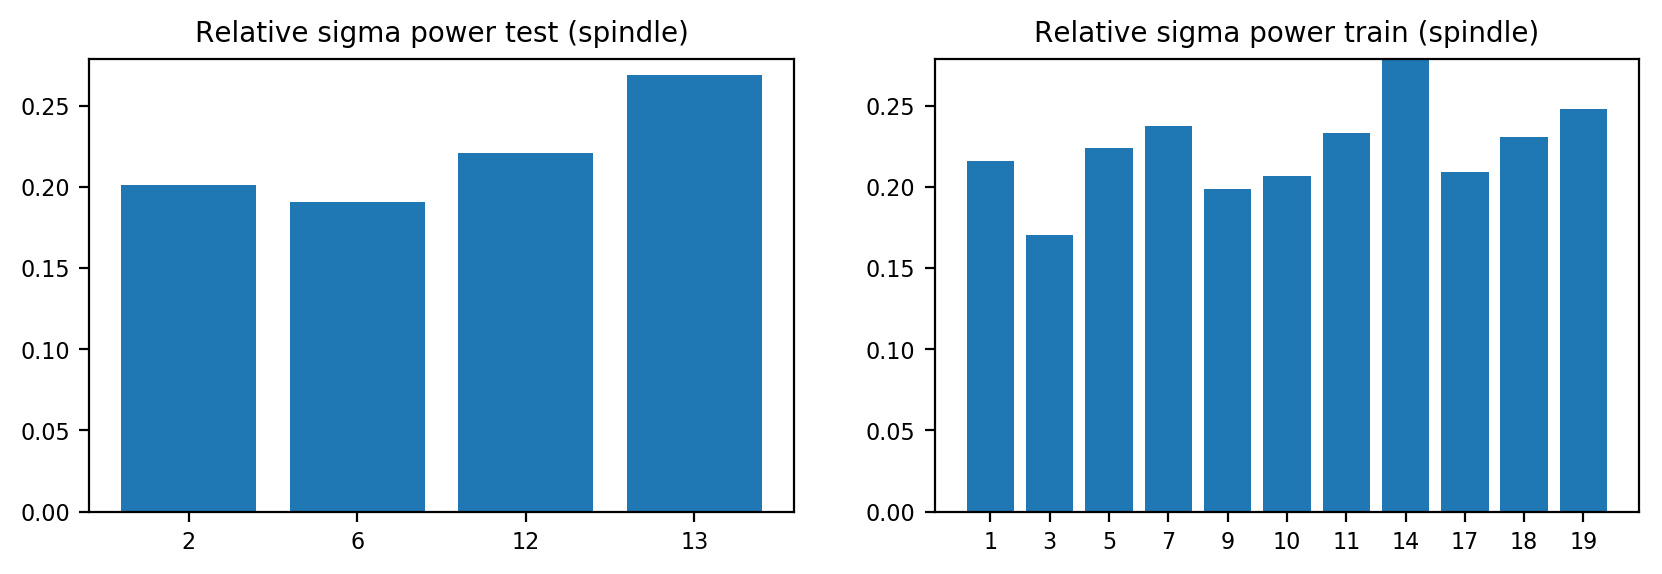

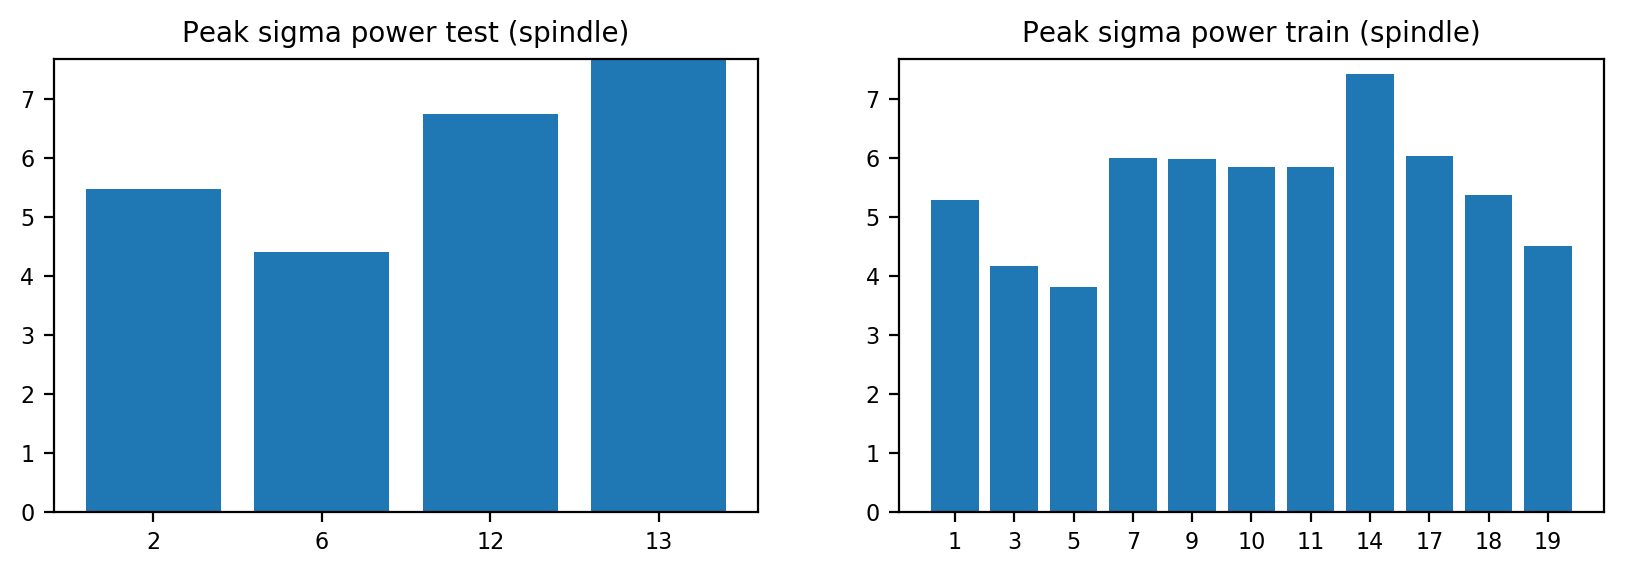

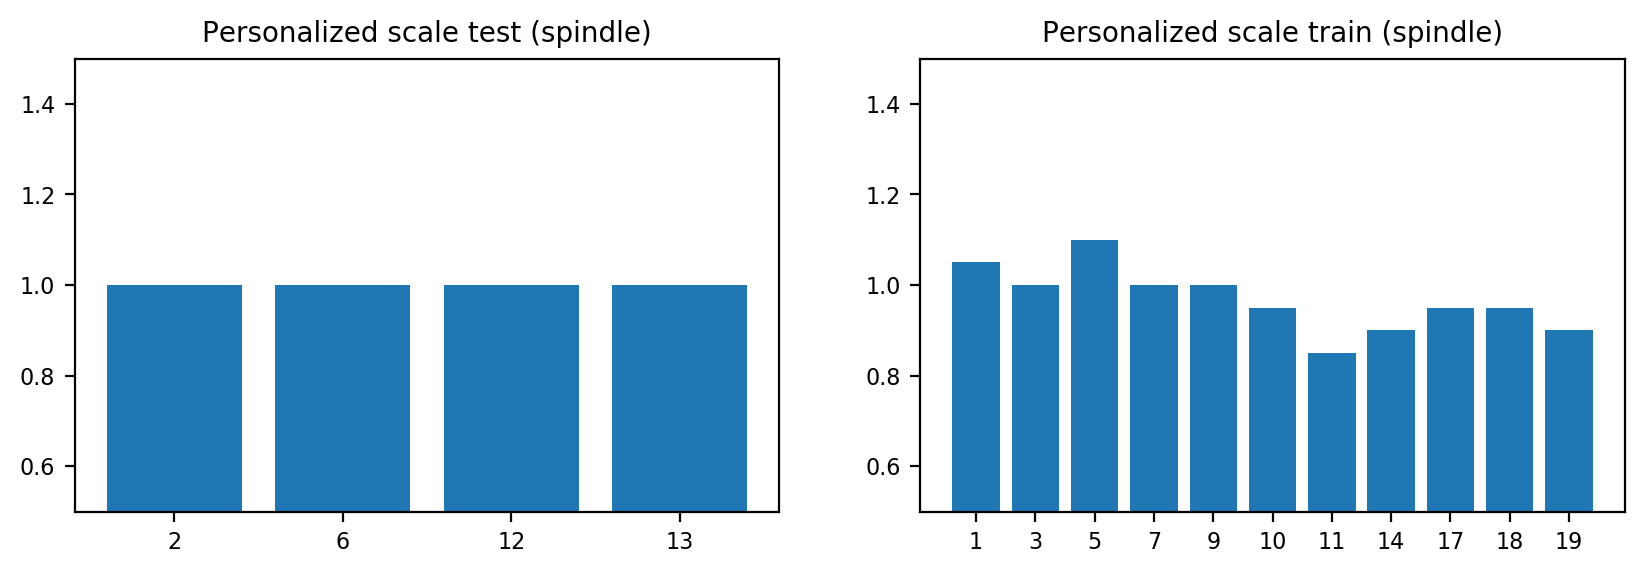

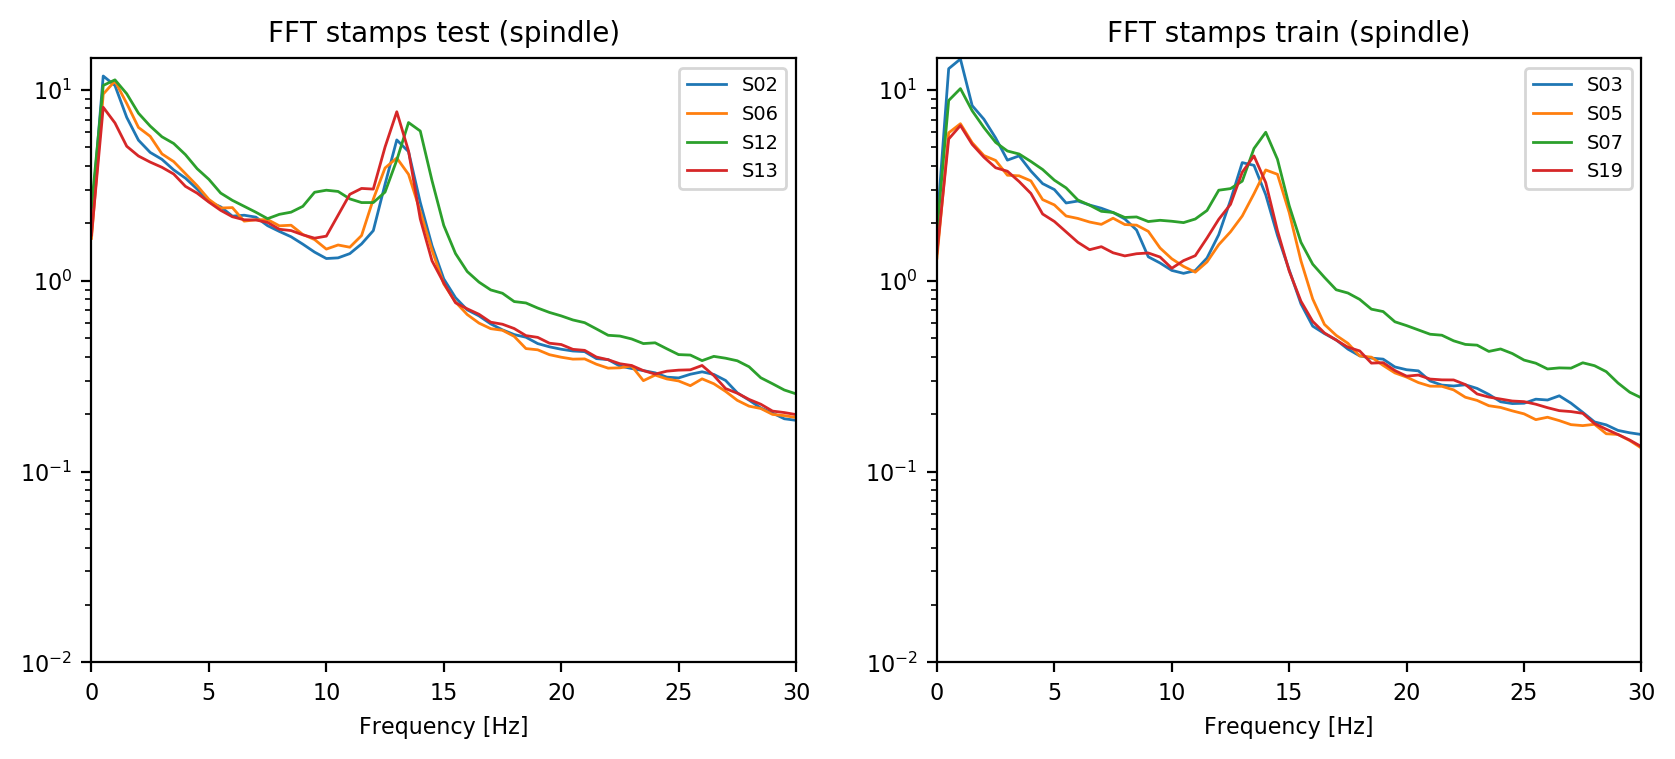

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
max_y = max(max(all_power_sigma_test), max(all_power_sigma_train))
ax[0].set_title('Sigma power test (%s)' % dataset.event_name, fontsize=10)
ax[0].bar(np.arange(len(dataset.test_ids)), all_power_sigma_test, bottom=None)
ax[0].set_xticks(np.arange(len(dataset.test_ids)))
ax[0].set_xticklabels(dataset.test_ids)
ax[0].tick_params(labelsize=8)
ax[0].set_ylim([0, max_y])
ax[1].set_title('Sigma power train (%s)' % dataset.event_name, fontsize=10)
ax[1].bar(np.arange(len(dataset.train_ids)), all_power_sigma_train, bottom=None)
ax[1].set_xticks(np.arange(len(dataset.train_ids)))
ax[1].set_xticklabels(dataset.train_ids)
ax[1].tick_params(labelsize=8)
ax[1].set_ylim([0, max_y])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
max_y = max(max(all_relative_power_sigma_test), max(all_relative_power_sigma_train))
ax[0].set_title('Relative sigma power test (%s)' % dataset.event_name, fontsize=10)
ax[0].bar(np.arange(len(dataset.test_ids)), all_relative_power_sigma_test, bottom=None)
ax[0].set_xticks(np.arange(len(dataset.test_ids)))
ax[0].set_xticklabels(dataset.test_ids)
ax[0].tick_params(labelsize=8)
ax[0].set_ylim([0, max_y])
ax[1].set_title('Relative sigma power train (%s)' % dataset.event_name, fontsize=10)
ax[1].bar(np.arange(len(dataset.train_ids)), all_relative_power_sigma_train, bottom=None)
ax[1].set_xticks(np.arange(len(dataset.train_ids)))
ax[1].set_xticklabels(dataset.train_ids)
ax[1].tick_params(labelsize=8)
ax[1].set_ylim([0, max_y])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
max_y = max(max(all_peak_power_sigma_test), max(all_peak_power_sigma_train))
ax[0].set_title('Peak sigma power test (%s)' % dataset.event_name, fontsize=10)
ax[0].bar(np.arange(len(dataset.test_ids)), all_peak_power_sigma_test, bottom=None)
ax[0].set_xticks(np.arange(len(dataset.test_ids)))
ax[0].set_xticklabels(dataset.test_ids)
ax[0].tick_params(labelsize=8)
ax[0].set_ylim([0, max_y])
ax[1].set_title('Peak sigma power train (%s)' % dataset.event_name, fontsize=10)
ax[1].bar(np.arange(len(dataset.train_ids)), all_peak_power_sigma_train, bottom=None)
ax[1].set_xticks(np.arange(len(dataset.train_ids)))
ax[1].set_xticklabels(dataset.train_ids)
ax[1].tick_params(labelsize=8)
ax[1].set_ylim([0, max_y])
plt.show()

# if dataset.event_name == constants.SPINDLE:
#     mu_test = [0.46, 0.34, 0.36, 0.60]
#     mu_train = [0.42, 0.36, 0.50, 0.46, 0.32, 0.44, 0.58, 0.54, 0.44, 0.34, 0.64]
# else:
#     mu_test = [0.54, 0.28, 0.32, 0.38]
#     mu_train = [0.5, 0.44, 0.5, 0.34, 0.26, 0.32, 0.46, 0.44, 0.44, 0.32, 0.58]
    
# fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
# max_y = max(max(mu_test), max(mu_train))
# ax[0].set_title('Personalized $\mu$ test (%s)' % dataset.event_name, fontsize=10)
# ax[0].bar(np.arange(len(dataset.test_ids)), mu_test, bottom=None)
# ax[0].set_xticks(np.arange(len(dataset.test_ids)))
# ax[0].set_xticklabels(dataset.test_ids)
# ax[0].tick_params(labelsize=8)
# ax[0].set_ylim([0, max_y])
# ax[1].set_title('Personalized $\mu$ train (%s)' % dataset.event_name, fontsize=10)
# ax[1].bar(np.arange(len(dataset.train_ids)), mu_train, bottom=None)
# ax[1].set_xticks(np.arange(len(dataset.train_ids)))
# ax[1].set_xticklabels(dataset.train_ids)
# ax[1].tick_params(labelsize=8)
# ax[1].set_ylim([0, max_y])
# plt.show()

if dataset.event_name == constants.SPINDLE:
    scale_test = [1.0, 1.0, 1.0, 1.0]
    scale_train = [1.05, 1, 1.1, 1, 1, .95, .85, .9, .95, .95, .9]
else:
    pass
    
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)
ax[0].set_title('Personalized scale test (%s)' % dataset.event_name, fontsize=10)
ax[0].bar(np.arange(len(dataset.test_ids)), scale_test, bottom=None)
ax[0].set_xticks(np.arange(len(dataset.test_ids)))
ax[0].set_xticklabels(dataset.test_ids)
ax[0].tick_params(labelsize=8)
ax[0].set_ylim([0.5, 1.5])
ax[1].set_title('Personalized scale train (%s)' % dataset.event_name, fontsize=10)
ax[1].bar(np.arange(len(dataset.train_ids)), scale_train, bottom=None)
ax[1].set_xticks(np.arange(len(dataset.train_ids)))
ax[1].set_xticklabels(dataset.train_ids)
ax[1].tick_params(labelsize=8)
ax[1].set_ylim([0.5, 1.5])
plt.show()

max_y = max_power + 0.1
min_y = 1e-2
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
ax[0].set_title('FFT stamps test (%s)' % dataset.event_name, fontsize=10)
for k, subject_id in enumerate(dataset.test_ids):
    ax[0].plot(all_freq, all_power_test[k], label='S%02d' % subject_id, linewidth=1)
ax[0].set_xlabel('Frequency [Hz]', fontsize=8)
ax[0].tick_params(labelsize=8)
ax[0].set_xlim([0, 30])
ax[0].set_ylim([min_y, max_y])
ax[0].legend(loc='upper right', fontsize=7)
ax[0].set_yscale('log')
ax[1].set_title('FFT stamps train (%s)' % dataset.event_name, fontsize=10)
subset_train = [3, 5, 7, 19]
for k, subject_id in enumerate(dataset.train_ids):
    if subject_id in subset_train:
        ax[1].plot(all_freq, all_power_train[k], label='S%02d' % subject_id, linewidth=1)
ax[1].set_xlabel('Frequency [Hz]', fontsize=8)
ax[1].tick_params(labelsize=8)
ax[1].set_xlim([0, 30])
ax[1].set_ylim([min_y, max_y])
ax[1].legend(loc='upper right', fontsize=7)
ax[1].set_yscale('log')
plt.show()

## Checking general numbers

In [ ]:
print('Sample frequency:', dataset.fs)
print('Page duration and size:', dataset.page_duration, dataset.page_size)
print('Registers ids:', dataset.all_ids)
print('Number of loaded registers:', len(dataset.data))
print('')
print('Train set IDs:', dataset.train_ids)
print('Test set IDs:', dataset.test_ids)

## Distribution of signal

In [ ]:
n_ids = len(dataset.all_ids)
print('N subjects:', n_ids)

n_rows = 4
n_cols = 4

fig, ax = plt.subplots(n_rows, n_cols, dpi=100, figsize=(13, 4), sharex=True)
for i, sub_id in enumerate(dataset.all_ids):
    this_row = int(i / n_cols)
    this_col = i - this_row * n_cols
    n2_signal, _ = dataset.get_subject_data(sub_id, normalize_clip=True)
    ax[this_row, this_col].hist(n2_signal.flatten(), label='ID %02d' % sub_id, bins=40, color='k', alpha=0.6)
    ax[this_row, this_col].set_yticks([])
    ax[this_row, this_col].set_xlim([-10, 10])
    # ax[this_row, this_col].set_xlim([-150, 150])
    ax[this_row, this_col].legend(loc='upper right')
    if this_row == n_rows-1:
        ax[this_row, this_col].set_xlabel('Signal value')

for j in range(i + 1, n_rows * n_cols):
    this_row = int(j / n_cols)
    this_col = j - this_row * n_cols
    ax[this_row, this_col].set_yticks([])
    if this_row == n_rows-1:
        ax[this_row, this_col].set_xlabel('Signal value')

fig.suptitle('Distribution of normalized EEG signals during N2 pages (MASS database)')
# plt.tight_layout()
plt.show()

## Check one subject

In [3]:
def plot_subject_global(signal, fs, pages, page_size, marks_1, marks_2):
    time_axis = np.arange(signal.size) / fs
    max_time = time_axis[-1]
    
    n_pages = np.ceil(signal.size / page_size).astype(int)
    n2_stages = np.zeros(n_pages, dtype=np.uint8)
    for page in pages:
        n2_stages[page] = 1
    
    marks_1_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_2_in_page = np.zeros(n_pages, dtype=np.int32)
    marks_1_n2_without_marks = 0
    marks_2_n2_without_marks = 0
    marks_both_n2_without_marks = 0
    for page in pages:
        start_sample = page * page_size
        end_sample = (page+1) * page_size
        marks_1_presence = np.sum(marks_1[start_sample:end_sample])
        marks_2_presence = np.sum(marks_2[start_sample:end_sample])
        if marks_1_presence == 0:
            marks_1_n2_without_marks += 1
        if marks_2_presence == 0:
            marks_2_n2_without_marks += 1
        if marks_1_presence == 0 and marks_2_presence == 0:
            marks_both_n2_without_marks += 1
        marks_1_in_page[page] = marks_1_presence
        marks_2_in_page[page] = marks_2_presence
    
    print('Number of N2 pages without E1 marks: %d' % marks_1_n2_without_marks)
    print('Number of N2 pages without E2 marks: %d' % marks_2_n2_without_marks)
    print('Number of N2 pages without any marks: %d' % marks_both_n2_without_marks)
    

    fig, ax = plt.subplots(4, 1, figsize=(15, 7))
    
    ax[0].set_title('Normalized EEG Signal')
    ax[0].plot(time_axis, signal)
    ax[0].set_xlabel('Time [s]')
    ax[0].set_xlim([0, max_time])

    ax[1].set_title('N2 pages (white is active)')
    ax[1].imshow(n2_stages[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray', extent=[0, max_time, 0, 1])
    ax[1].axis('off')
    
    ax[2].set_title('Expert 1 marks presence (white is active)')
    ax[2].imshow(marks_1_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[2].axis('off')
    
    ax[3].set_title('Expert 2 marks presence (white is active)')
    ax[3].imshow(marks_2_in_page[np.newaxis, :], interpolation=None, aspect='auto', extent=[0, max_time, 0, 1], cmap='gray')
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()

### Complete register visualization

In [4]:
# Registers ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 19]
subject_id = 1

In [7]:
ind_dict = dataset.data[subject_id]
signal, marks_1 = dataset.get_subject_data(subject_id, which_expert=1, )
signal = ind_dict[KEY_EEG]
pages = ind_dict[KEY_USEFUL_PAGES]
marks_1 = ind_dict['%s_1' % KEY_MARKS]
marks_2 = ind_dict['%s_2' % KEY_MARKS]

print('Loaded subject ID %s' % subject_id)
print('Signal size %d. Number of pages %d' % (signal.shape[0], pages.shape[0]))

Normalizing with Global STD of 16.482037


NameError: name 'KEY_USEFUL_PAGES' is not defined

In [8]:
plot_subject_global(signal, dataset.fs, pages, dataset.page_size, marks_1, marks_2)

NameError: name 'pages' is not defined

## Marks statistics from saved data

In [ ]:
durations_1 = np.diff(marks_1_stamps)[:, 0] / dataset.fs
durations_2 = np.diff(marks_2_stamps)[:, 0] / dataset.fs

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 4), dpi=100)
ax[0].hist(durations_1, bins=20, color='k', alpha=0.6)
ax[0].set_title('Distribution of E1 marks durations in Subject %02d (Preprocessed)' % subject_id)
ax[1].hist(durations_2, bins=20, color='k', alpha=0.6)
ax[1].set_title('Distribution of E2 marks durations in Subject %02d (Preprocessed)' % subject_id)
ax[1].set_xlabel('Duration [s]')
plt.tight_layout()
plt.show()

In [ ]:
# Compute statistics comparing E1 and E2

# By sample
print('By Sample Stats between E1 and E2:')
bs_metrics = by_sample_confusion(marks_1, marks_2, input_is_binary=True)
bs_iou = by_sample_iou(marks_1, marks_2, input_is_binary=True)
print('BS IoU: %1.4f' % bs_iou)
pprint.pprint(bs_metrics)

# By event
print('\nBy Event stats between E1 and E2:')
print('Number of marks from E1: %d' % marks_1_stamps.shape[0])
print('Number of marks from E2: %d' % marks_2_stamps.shape[0])
iou_array, idx_e2_marks = matching(marks_1_stamps, marks_2_stamps)
nonzero_iou_array = iou_array[iou_array > 0]
print('Number of nonzero iou marks:', nonzero_iou_array.shape[0])
be_metrics = by_event_confusion(marks_1_stamps, marks_2_stamps, iou_array=iou_array)
pprint.pprint(be_metrics)

In [ ]:
fig = plt.figure(figsize=(10,2), dpi=100)
plt.hist(nonzero_iou_array, bins=[i*0.1 for i in range(11)], color='k', alpha=0.6)
plt.xlabel('IoU Value')
plt.title('Distribution of nonzero IoU between E1 and E2 in Subject %02d (mean %1.4f)' % (subject_id, be_metrics['mean_nonzero_iou']))
plt.xlim([0, 1])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].set_title('E1 marks')
ax[0].scatter(durations_1, iou_array, alpha=0.3)
ax[0].set_xlabel('Duration [s]')
ax[0].set_ylabel('IoU')

iou_array_e2 = np.zeros(durations_2.shape)
for i, idx in enumerate(idx_e2_marks):
    if idx != -1:
        iou_array_e2[idx] = iou_array[i]

ax[1].set_title('E2 marks')
ax[1].scatter(durations_2, iou_array_e2, alpha=0.3)
ax[1].set_xlabel('Duration [s]')

plt.tight_layout()
plt.show()

In [ ]:
# durations_2_matched = np.zeros(durations_1.shape)
durations_1_matched = []
durations_2_matched = []
for i, idx in enumerate(idx_e2_marks):
    if idx != -1:
        durations_1_matched.append(durations_1[i])
        durations_2_matched.append(durations_2[idx])

fig = plt.figure(figsize=(5, 5), dpi=100)
plt.title('Durations between matched expert marks')
plt.scatter(durations_1_matched, durations_2_matched, alpha=0.2, color='k')
plt.plot([0, 3], [0, 3], color='r')
plt.xlabel('E1 duration [s]')
plt.ylabel('E2 duration [s]')
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.axis('square')
plt.show()

## Page visualization

In [5]:
n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1, verbose=True)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2, verbose=True)
pages = dataset.get_subject_pages(subject_id)

Normalization with stats from pages containing true events.
Normalizing with Global STD of 16.482037
Getting ID 1, 1445 wn pages, Expert 1
Normalization with stats from pages containing true events.
Normalizing with Global STD of 16.482037
Getting ID 1, 1445 wn pages, Expert 2


In [6]:
print('Number of n2 pages:', n2_signal.shape)
tmp = np.sum(n2_marks_1, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E1 marks:', tmp)
tmp = np.sum(n2_marks_2, axis=1)
tmp = sum((tmp==0).astype(int))
print('Number of pages without E2 marks:', tmp)

Number of n2 pages: (1445, 4000)
Number of pages without E1 marks: 897
Number of pages without E2 marks: 764


In [7]:
n2_marks_1_stamps = seq2stamp_with_pages(n2_marks_1, pages)
n2_marks_2_stamps = seq2stamp_with_pages(n2_marks_2, pages)
print('Number of E1 marks:', n2_marks_1_stamps.shape)
print('Number of E2 marks:', n2_marks_2_stamps.shape)

Number of E1 marks: (1044, 2)
Number of E2 marks: (2379, 2)


In [8]:
def plot_page(page, signal, e1_marks, e2_marks, n2_pages, fs):
    fig = plt.figure(figsize=(12, 5), dpi=100) 
    gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1]) 
    
    page = page - 1
    
    segment_signal = signal[page, :]
    segment_e1_marks = e1_marks[page, :]
    segment_e2_marks = e2_marks[page, :]
    time_axis = np.arange(signal.shape[1])/fs
    
    # Signal
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(time_axis, segment_signal)
    ax0.set_yticks([])
    ax0.set_xlim([0, 20])
    ax0.set_ylim([-10, 10])
    ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
    ax0.set_xticks([0, 5, 10, 15, 20])
    ax0.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax0.grid(b=True, axis='x', which='minor')
    
    # Expert mark
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(segment_e1_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax2.axis('off')
    ax2.set_title('Expert 1 (white is active)')
    
    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(segment_e2_marks[np.newaxis, :], interpolation=None, aspect='auto', cmap='gray')
    ax3.axis('off')
    ax3.set_title('Expert 2 (White is active)')
    
    plt.tight_layout()
    plt.show()

In [9]:
widgets.interact(
    lambda page: plot_page(page, n2_signal, n2_marks_1, n2_marks_2, pages, dataset.fs),
    page=widgets.IntSlider(min=1,max=n2_signal.shape[0],step=1,value=1, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='page', max=1445, min=1), Output…

## Spindle Activity Distribution across training examples

In [ ]:
# Load all training pages

# Get training set ids
print('Loading training set and splitting')
all_train_ids = dataset.train_ids
# We won't split train intro train and val sets, it doesn't matter

# Get data
# We don't add border nor augment pages to don't perturb spindle activity INSIDE the page
_, y_train_1 = dataset.get_subset_data(
    all_train_ids, augmented_page=False, border_size=0,
    which_expert=1, verbose=False)
_, y_train_2 = dataset.get_subset_data(
    all_train_ids, augmented_page=False, border_size=0,
    which_expert=2, verbose=False)
print('Pages loaded')
    
# Now count samples with spindle activity
activity_train_1 = []
for sub_marks in y_train_1:
    this_activity = np.sum(sub_marks, axis=1)
    activity_train_1.append(this_activity)
    print(this_activity.shape)
activity_train_2 = []
for sub_marks in y_train_2:
    this_activity = np.sum(sub_marks, axis=1)
    activity_train_2.append(this_activity)
    print(this_activity.shape)  
# Now concatenate everything
fs = 200
all_activity_train_1 = np.concatenate(activity_train_1, axis=0) / fs
all_activity_train_2 = np.concatenate(activity_train_2, axis=0) / fs
print('All train pages:', all_activity_train_1.shape)
print('All train pages:', all_activity_train_2.shape)

In [ ]:
ntotal = all_activity_train_1.size
nzero_1 = np.where(all_activity_train_1==0)[0].size
nzero_2 = np.where(all_activity_train_2==0)[0].size
nonzero_activity_train_1 = all_activity_train_1[np.where(all_activity_train_1>0)]
nonzero_activity_train_2 = all_activity_train_2[np.where(all_activity_train_2>0)]

print('--------------')
print('Expert 1 Stats')
print('--------------')
print('Number of pages:', ntotal)
print('Number of zero activity pages:', nzero_1, '(%1.4f%% of training set)' % (100*nzero_1 / ntotal))
mean_1 = np.mean(nonzero_activity_train_1)
median_1_all = np.median(all_activity_train_1)
print('Mean nonzero activity: %1.2f' %  mean_1)
print('Median nonzero activity: %1.2f' %  np.median(nonzero_activity_train_1))
print('Max nonzero activity: %1.2f' %  np.max(nonzero_activity_train_1))
print('Median of all activity: %1.2f' % np.median(all_activity_train_1))

print('--------------')
print('Expert 2 Stats')
print('--------------')
print('Number of pages:', ntotal)
print('Number of zero activity pages:', nzero_2, '(%1.4f%% of training set)' % (100*nzero_2 / ntotal))
mean_2 = np.mean(nonzero_activity_train_2)
median_2_all = np.median(all_activity_train_2)
print('Mean nonzero activity: %1.2f' %  mean_2)
print('Median nonzero activity: %1.2f' %  np.median(nonzero_activity_train_2))
print('Max nonzero activity: %1.2f' %  np.max(nonzero_activity_train_2))
print('Median of all activity: %1.2f' % np.median(all_activity_train_2))

max_value = 400
bins = 70

fig, ax = plt.subplots(2, 1, dpi=100, figsize=(12, 7), sharex=True)
ax[0].hist(nonzero_activity_train_1, bins=bins, color='0.7')
ax[0].set_title('Distribution of total sleep spindle activity duration in pages with nonzero activity (Expert 1)')
ax[0].set_ylabel('Frequency')
ax[0].plot([mean_1, mean_1], [0, max_value], 'r--', label='Mean of nonzero %1.2f [s]' % mean_1)
ax[0].plot([median_1_all, median_1_all], [0, max_value], 'b--', label='Median of ALL pages %1.2f [s]' % median_1_all)
ax[0].legend(loc='upper right')

ax[1].hist(nonzero_activity_train_2, bins=bins, color='0.7')
ax[1].set_title('Distribution of total sleep spindle activity duration in pages with nonzero activity (Expert 2)')
ax[1].set_xlabel('Duration [s]')
ax[1].set_ylabel('Frequency')
ax[1].plot([mean_2, mean_2], [0, max_value], 'r--', label='Mean of nonzero %1.2f [s]' % mean_2)
ax[1].plot([median_2_all, median_2_all], [0, max_value], 'b--', label='Median of ALL pages %1.2f [s]' % median_2_all)
ax[1].legend(loc='upper right')
max_activity = np.max(nonzero_activity_train_2)
ax[1].set_xlim([0, max_activity])
ax[1].set_xticks([i*0.5 for i in range(int(2*max_activity))])

plt.show()

In [ ]:
ntotal = all_activity_train_1.size
nzero_1 = np.where(all_activity_train_1==0)[0].size
nonzero_activity_train_1 = all_activity_train_1[np.where(all_activity_train_1>0)]

print('--------------')
print('Expert 1 Stats')
print('--------------')
print('Number of pages:', ntotal)
print('Number of zero activity pages:', nzero_1, '(%1.4f%% of training set)' % (100*nzero_1 / ntotal))
mean_1 = np.mean(nonzero_activity_train_1)
median_1_all = np.median(all_activity_train_1)
print('Mean nonzero activity: %1.2f' %  mean_1)
print('Median nonzero activity: %1.2f' %  np.median(nonzero_activity_train_1))
print('Max nonzero activity: %1.2f' %  np.max(nonzero_activity_train_1))
print('Median of all activity: %1.2f' % np.median(all_activity_train_1))

max_value = 3000
bins = 70

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(7, 6), sharex=True)
# ax.hist(nonzero_activity_train_1, bins=bins, color='0.7')
ax.hist(all_activity_train_1, bins=bins, color='0.5')
ax.set_title('Histogram of sleep spindle activity inside pages of training set (MASS, E1)', fontsize=12)
ax.set_ylabel('Count')
# ax.plot([mean_1, mean_1], [0, max_value], 'r--', label='Mean of nonzero %1.2f [s]' % mean_1)
ax.plot([median_1_all, median_1_all], [0, max_value], 'b--', label='Median: %1.2f [s]' % median_1_all)
ax.legend(loc='upper right')
ax.set_xlabel('Sleep spindle activity inside a page [s]')
max_activity = np.max(all_activity_train_1)
ax.set_xlim([-0.1, max_activity])
ax.set_xticks([i*0.5 for i in range(int(2*max_activity))])
ax.annotate("", xy=(1, 3300), xytext=(0.1, 3300), arrowprops=dict(arrowstyle="<-"))
ax.annotate("Zero activity", xy=(2, 3280), xytext=(1.1, 3280))

plt.show()